In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf  # For tf.data and preprocessing only.
import keras
from keras import layers
from keras import ops
from keras import preprocessing
import os
from keras.preprocessing.image import load_img, img_to_array
import torch


In [ ]:
tf. config. list_physical_devices

<function tensorflow.python.framework.config.list_physical_devices(device_type=None)>

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
import torch
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)} is available.")
else:
    print("No GPU available. Training will run on CPU.")

In [ ]:
print(torch.version.cuda)  # e.g., "12.6" if it's correctly linked with CUDA 12.6

12.6


In [ ]:
num_classes = 7
input_shape = (224,224, 3)

patch_size = (16,16)  # 2-by-2 sized patches
#lower = better but more computationally taxing

dropout_rate = 0.2  # Dropout rate

#attention
num_heads = 8  # Attention heads #needed to calculate feature dimension, which is the number of features per attention head
#higher = better but more computationally taxing

embed_dim = 32  # Embedding dimension
#higher = better but more computationally taxing

#classifier
num_mlp = 196  # MLP layer size
#^
#CALCULATING THIS IS DEPENDENT ON PATCH SIZE AND INPUT SHAPE

'''
To calculate MLP size

Divide input height and width with it's corresponding patch size

so for our model

224/16 = 14

224/16 = 14

then multiply the two values to find MLP size

14 x 14 = 196
'''

# Convert embedded patches to query, key, and values with a learnable additive
# value
qkv_bias = True
window_size = 1  # Size of attention window
shift_size = 1  # Size of shifting window
#higher = better but more computationally taxing

image_dimension = 224  # Initial image size

num_patch_x = input_shape[0] // patch_size[0]
num_patch_y = input_shape[1] // patch_size[1]

learning_rate = 1e-3
batch_size = 16
num_epochs = 50
validation_split = 0.1
weight_decay = 0.0001
label_smoothing = 0.1

In [ ]:
# drive.mount('/content/drive')

def load_image_dataset(directory_path, img_size=(224,224), batch_size=batch_size, test_split=0.1):
    # Create training dataset
    train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        directory_path,
        validation_split=test_split,
        subset='training',
        seed=123,
        image_size=img_size,
        batch_size=None  # Important: set to None to get full dataset
    )

    # Create validation/test dataset
    test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        directory_path,
        validation_split=test_split,
        subset='validation',
        seed=123,
        image_size=img_size,
        batch_size=None  # Important: set to None to get full dataset
    )

    # Convert datasets to numpy arrays
    x_train, y_train = [], []
    for image, label in train_dataset:
        x_train.append(image.numpy())
        y_train.append(label.numpy())

    x_test, y_test = [], []
    for image, label in test_dataset:
        x_test.append(image.numpy())
        y_test.append(label.numpy())

    # Concatenate and convert to numpy arrays
    x_train = np.array(x_train)
    y_train = np.array(y_train).flatten()
    x_test = np.array(x_test)
    y_test = np.array(y_test).flatten()

    return (x_train, y_train), (x_test, y_test)

# Example usage
directory_path = "D:/p3 dataset/skin_cancer_segmented"


Found 10015 files belonging to 7 classes.
Using 9014 files for training.
Found 10015 files belonging to 7 classes.
Using 1001 files for validation.
x_train shape: (8112, 224, 224, 3) - y_train shape: (8112, 7)
x_test shape: (1001, 224, 224, 3) - y_test shape: (1001, 7)


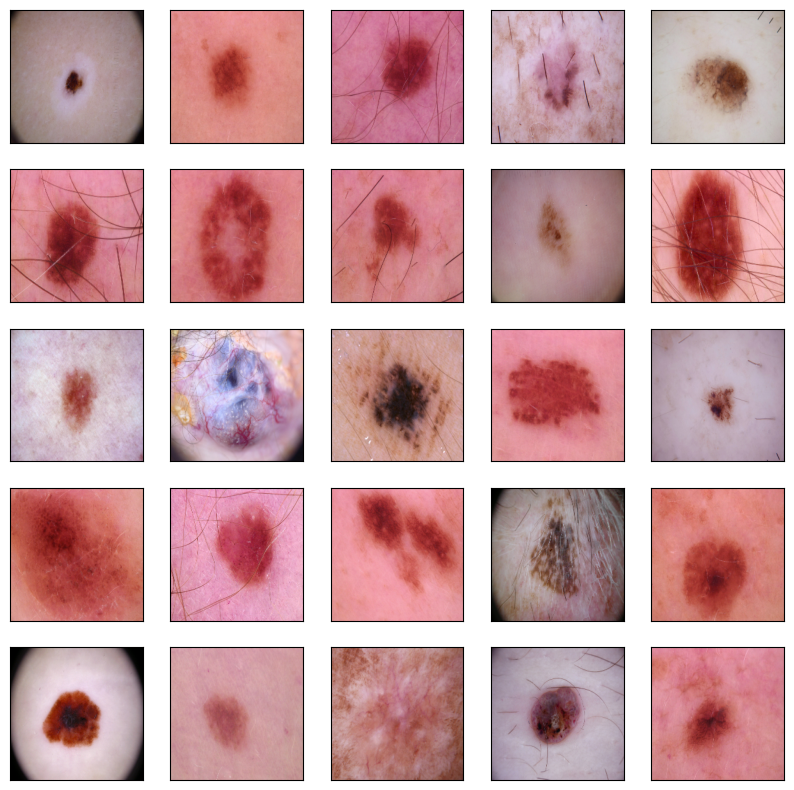

In [ ]:
(x_train, y_train), (x_test, y_test) = load_image_dataset(directory_path)

x_train = x_train / 255.0
x_test = x_test / 255.0
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
num_train_samples = int(len(x_train) * (1 - validation_split))
num_val_samples = len(x_train) - num_train_samples
x_train, x_val = np.split(x_train, [num_train_samples])
y_train, y_val = np.split(y_train, [num_train_samples])
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i])
plt.show()


In [ ]:
def window_partition(x, window_size):
    _, height, width, channels = x.shape
    patch_num_y = height // window_size
    patch_num_x = width // window_size
    x = ops.reshape(
        x,
        (
            -1,
            patch_num_y,
            window_size,
            patch_num_x,
            window_size,
            channels,
        ),
    )
    x = ops.transpose(x, (0, 1, 3, 2, 4, 5))
    windows = ops.reshape(x, (-1, window_size, window_size, channels))
    return windows


def window_reverse(windows, window_size, height, width, channels):
    patch_num_y = height // window_size
    patch_num_x = width // window_size
    x = ops.reshape(
        windows,
        (
            -1,
            patch_num_y,
            patch_num_x,
            window_size,
            window_size,
            channels,
        ),
    )
    x = ops.transpose(x, (0, 1, 3, 2, 4, 5))
    x = ops.reshape(x, (-1, height, width, channels))
    return x

In [ ]:
from keras.saving import register_keras_serializable


@register_keras_serializable()
class WindowAttention(layers.Layer):
    def __init__(
        self,
        dim,
        window_size,
        num_heads,
        qkv_bias=True,
        dropout_rate=0.0,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.dim = dim
        self.window_size = window_size
        self.num_heads = num_heads
        self.scale = (dim // num_heads) ** -0.5
        self.qkv = layers.Dense(dim * 3, use_bias=qkv_bias)
        self.dropout = layers.Dropout(dropout_rate)
        self.proj = layers.Dense(dim)

        num_window_elements = (2 * self.window_size[0] - 1) * (
            2 * self.window_size[1] - 1
        )
        self.relative_position_bias_table = self.add_weight(
            shape=(num_window_elements, self.num_heads),
            initializer=keras.initializers.Zeros(),
            trainable=True,
        )
        coords_h = np.arange(self.window_size[0])
        coords_w = np.arange(self.window_size[1])
        coords_matrix = np.meshgrid(coords_h, coords_w, indexing="ij")
        coords = np.stack(coords_matrix)
        coords_flatten = coords.reshape(2, -1)
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]
        relative_coords = relative_coords.transpose([1, 2, 0])
        relative_coords[:, :, 0] += self.window_size[0] - 1
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1)

        self.relative_position_index = keras.Variable(
            initializer=relative_position_index,
            shape=relative_position_index.shape,
            dtype="int",
            trainable=False,
        )

    def call(self, x, mask=None):
        _, size, channels = x.shape
        head_dim = channels // self.num_heads
        x_qkv = self.qkv(x)
        x_qkv = ops.reshape(x_qkv, (-1, size, 3, self.num_heads, head_dim))
        x_qkv = ops.transpose(x_qkv, (2, 0, 3, 1, 4))
        q, k, v = x_qkv[0], x_qkv[1], x_qkv[2]
        q = q * self.scale
        k = ops.transpose(k, (0, 1, 3, 2))
        attn = q @ k

        num_window_elements = self.window_size[0] * self.window_size[1]
        relative_position_index_flat = ops.reshape(self.relative_position_index, (-1,))
        relative_position_bias = ops.take(
            self.relative_position_bias_table,
            relative_position_index_flat,
            axis=0,
        )
        relative_position_bias = ops.reshape(
            relative_position_bias,
            (num_window_elements, num_window_elements, -1),
        )
        relative_position_bias = ops.transpose(relative_position_bias, (2, 0, 1))
        attn = attn + ops.expand_dims(relative_position_bias, axis=0)

        if mask is not None:
            nW = mask.shape[0]
            mask_float = ops.cast(
                ops.expand_dims(ops.expand_dims(mask, axis=1), axis=0),
                "float32",
            )
            attn = ops.reshape(attn, (-1, nW, self.num_heads, size, size)) + mask_float
            attn = ops.reshape(attn, (-1, self.num_heads, size, size))
            attn = keras.activations.softmax(attn, axis=-1)
        else:
            attn = keras.activations.softmax(attn, axis=-1)
        attn = self.dropout(attn)

        x_qkv = attn @ v
        x_qkv = ops.transpose(x_qkv, (0, 2, 1, 3))
        x_qkv = ops.reshape(x_qkv, (-1, size, channels))
        x_qkv = self.proj(x_qkv)
        x_qkv = self.dropout(x_qkv)
        return x_qkv

In [ ]:
@register_keras_serializable()
class SwinTransformer(layers.Layer):
    def __init__(
        self,
        dim,
        num_patch,
        num_heads,
        window_size=7,
        shift_size=0,
        num_mlp=1024,
        qkv_bias=True,
        dropout_rate=0.0,
        **kwargs,
    ):
        super().__init__(**kwargs)

        self.dim = dim  # number of input dimensions
        self.num_patch = num_patch  # number of embedded patches
        self.num_heads = num_heads  # number of attention heads
        self.window_size = window_size  # size of window
        self.shift_size = shift_size  # size of window shift
        self.num_mlp = num_mlp  # number of MLP nodes

        self.norm1 = layers.LayerNormalization(epsilon=1e-5)
        self.attn = WindowAttention(
            dim,
            window_size=(self.window_size, self.window_size),
            num_heads=num_heads,
            qkv_bias=qkv_bias,
            dropout_rate=dropout_rate,
        )
        self.drop_path = layers.Dropout(dropout_rate)
        self.norm2 = layers.LayerNormalization(epsilon=1e-5, name="norm2")

        self.mlp = keras.Sequential(
            [
                layers.Dense(num_mlp),
                layers.Activation(keras.activations.gelu),
                layers.Dropout(dropout_rate),
                layers.Dense(dim),
                layers.Dropout(dropout_rate),
            ]
        )

        if min(self.num_patch) < self.window_size:
            self.shift_size = 0
            self.window_size = min(self.num_patch)

    def build(self, input_shape):
        if self.shift_size == 0:
            self.attn_mask = None
        else:
            height, width = self.num_patch
            h_slices = (
                slice(0, -self.window_size),
                slice(-self.window_size, -self.shift_size),
                slice(-self.shift_size, None),
            )
            w_slices = (
                slice(0, -self.window_size),
                slice(-self.window_size, -self.shift_size),
                slice(-self.shift_size, None),
            )
            mask_array = np.zeros((1, height, width, 1))
            count = 0
            for h in h_slices:
                for w in w_slices:
                    mask_array[:, h, w, :] = count
                    count += 1
            mask_array = ops.convert_to_tensor(mask_array)

            # mask array to windows
            mask_windows = window_partition(mask_array, self.window_size)
            mask_windows = ops.reshape(
                mask_windows, [-1, self.window_size * self.window_size]
            )
            attn_mask = ops.expand_dims(mask_windows, axis=1) - ops.expand_dims(
                mask_windows, axis=2
            )
            attn_mask = ops.where(attn_mask != 0, -100.0, attn_mask)
            attn_mask = ops.where(attn_mask == 0, 0.0, attn_mask)
            self.attn_mask = keras.Variable(
                initializer=attn_mask,
                shape=attn_mask.shape,
                dtype=attn_mask.dtype,
                trainable=False,
            )

    def call(self, x, training=False):
        height, width = self.num_patch
        _, num_patches_before, channels = x.shape
        x_skip = x
        x = self.norm1(x)
        x = ops.reshape(x, (-1, height, width, channels))
        if self.shift_size > 0:
            shifted_x = ops.roll(
                x, shift=[-self.shift_size, -self.shift_size], axis=[1, 2]
            )
        else:
            shifted_x = x

        x_windows = window_partition(shifted_x, self.window_size)
        x_windows = ops.reshape(
            x_windows, (-1, self.window_size * self.window_size, channels)
        )
        attn_windows = self.attn(x_windows, mask=self.attn_mask)

        attn_windows = ops.reshape(
            attn_windows,
            (-1, self.window_size, self.window_size, channels),
        )
        shifted_x = window_reverse(
            attn_windows, self.window_size, height, width, channels
        )
        if self.shift_size > 0:
            x = ops.roll(
                shifted_x, shift=[self.shift_size, self.shift_size], axis=[1, 2]
            )
        else:
            x = shifted_x

        x = ops.reshape(x, (-1, height * width, channels))
        x = self.drop_path(x, training=training)
        x = x_skip + x
        x_skip = x
        x = self.norm2(x)
        x = self.mlp(x)
        x = self.drop_path(x)
        x = x_skip + x
        return x

In [ ]:
# Using tf ops since it is only used in tf.data.
def patch_extract(images):
    batch_size = tf.shape(images)[0]
    patches = tf.image.extract_patches(
        images=images,
        sizes=(1, patch_size[0], patch_size[1], 1),
        strides=(1, patch_size[0], patch_size[1], 1),
        rates=(1, 1, 1, 1),
        padding="VALID",
    )
    patch_dim = patches.shape[-1]
    patch_num = patches.shape[1]
    return tf.reshape(patches, (batch_size, patch_num * patch_num, patch_dim))

@register_keras_serializable()
class PatchEmbedding(layers.Layer):
    def __init__(self, num_patch, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.num_patch = num_patch
        self.proj = layers.Dense(embed_dim)
        self.pos_embed = layers.Embedding(input_dim=num_patch, output_dim=embed_dim)

    def call(self, patch):
        pos = ops.arange(start=0, stop=self.num_patch)
        return self.proj(patch) + self.pos_embed(pos)

@register_keras_serializable()
class PatchMerging(keras.layers.Layer):
    def __init__(self, num_patch, embed_dim, **kwargs):
        super().__init__()
        self.num_patch = num_patch
        self.embed_dim = embed_dim
        self.linear_trans = layers.Dense(2 * embed_dim, use_bias=False)

    def call(self, x):
        height, width = self.num_patch
        _, _, C = x.shape
        x = ops.reshape(x, (-1, height, width, C))
        x0 = x[:, 0::2, 0::2, :]
        x1 = x[:, 1::2, 0::2, :]
        x2 = x[:, 0::2, 1::2, :]
        x3 = x[:, 1::2, 1::2, :]
        x = ops.concatenate((x0, x1, x2, x3), axis=-1)
        x = ops.reshape(x, (-1, (height // 2) * (width // 2), 4 * C))
        return self.linear_trans(x)

In [ ]:
def augment(x):
    x = tf.image.random_crop(x, size=(image_dimension, image_dimension, 3))
    x = tf.image.random_flip_left_right(x)
    return x


dataset = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .map(lambda x, y: (augment(x), y))
    .batch(batch_size=batch_size)
    .map(lambda x, y: (patch_extract(x), y))
    .prefetch(tf.data.experimental.AUTOTUNE)
)

dataset_val = (
    tf.data.Dataset.from_tensor_slices((x_val, y_val))
    .batch(batch_size=batch_size)
    .map(lambda x, y: (patch_extract(x), y))
    .prefetch(tf.data.experimental.AUTOTUNE)
)

dataset_test = (
    tf.data.Dataset.from_tensor_slices((x_test, y_test))
    .batch(batch_size=batch_size)
    .map(lambda x, y: (patch_extract(x), y))
    .prefetch(tf.data.experimental.AUTOTUNE)
)

In [ ]:
input = layers.Input(shape=(196, 768))
x = PatchEmbedding(num_patch_x * num_patch_y, embed_dim)(input)
x = SwinTransformer(
    dim=embed_dim,
    num_patch=(num_patch_x, num_patch_y),
    num_heads=num_heads,
    window_size=window_size,
    shift_size=0,
    num_mlp=num_mlp,
    qkv_bias=qkv_bias,
    dropout_rate=dropout_rate,
)(x)
x = SwinTransformer(
    dim=embed_dim,
    num_patch=(num_patch_x, num_patch_y),
    num_heads=num_heads,
    window_size=window_size,
    shift_size=shift_size,
    num_mlp=num_mlp,
    qkv_bias=qkv_bias,
    dropout_rate=dropout_rate,
)(x)
x = PatchMerging((num_patch_x, num_patch_y), embed_dim=embed_dim)(x)
x = layers.GlobalAveragePooling1D()(x)
output = layers.Dense(num_classes, activation="softmax")(x)

C:\Users\T2330128\AppData\Roaming\Python\Python312\site-packages\keras\src\ops\nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 8, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


In [ ]:
from tensorflow.keras.metrics import Precision, Recall

# Initialize Precision and Recall outside of the function
precision_metric = Precision()
recall_metric = Recall()

def f1_score(y_true, y_pred):
    precision = precision_metric(y_true, y_pred)
    recall = recall_metric(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

In [ ]:
model = keras.Model(input, output)

model.count_params()

73989

In [ ]:
model = keras.Model(input, output)


model.compile(
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing),
    optimizer=keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    ),
    metrics=[
        keras.metrics.CategoricalAccuracy(name="accuracy"),
        keras.metrics.Precision(name="precision"),
        keras.metrics.Recall(name="recall"),
        f1_score
    ],
)

history = model.fit(
    dataset,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_data=dataset_val,
)

Epoch 1/50
507/507 ━━━━━━━━━━━━━━━━━━━━ 55s 100ms/step - accuracy: 0.6592 - f1_score: 0.6137 - loss: 1.2818 - precision: 0.7387 - recall: 0.5185 - val_accuracy: 0.6752 - val_f1_score: 0.6168 - val_loss: 1.1947 - val_precision: 0.7755 - val_recall: 0.5554
Epoch 2/50
507/507 ━━━━━━━━━━━━━━━━━━━━ 53s 104ms/step - accuracy: 0.6644 - f1_score: 0.6175 - loss: 1.2148 - precision: 0.7728 - recall: 0.5156 - val_accuracy: 0.6231 - val_f1_score: 0.6186 - val_loss: 1.2108 - val_precision: 0.8599 - val_recall: 0.4424
Epoch 3/50
507/507 ━━━━━━━━━━━━━━━━━━━━ 50s 98ms/step - accuracy: 0.6671 - f1_score: 0.6182 - loss: 1.1850 - precision: 0.7842 - recall: 0.5216 - val_accuracy: 0.6508 - val_f1_score: 0.6207 - val_loss: 1.1874 - val_precision: 0.8891 - val_recall: 0.4268
Epoch 4/50
507/507 ━━━━━━━━━━━━━━━━━━━━ 50s 99ms/step - accuracy: 0.6715 - f1_score: 0.6208 - loss: 1.1659 - precision: 0.7974 - recall: 0.5265 - val_accuracy: 0.6663 - val_f1_score: 0.6241 - val_loss: 1.1837 - val_precision: 0.9095 - v

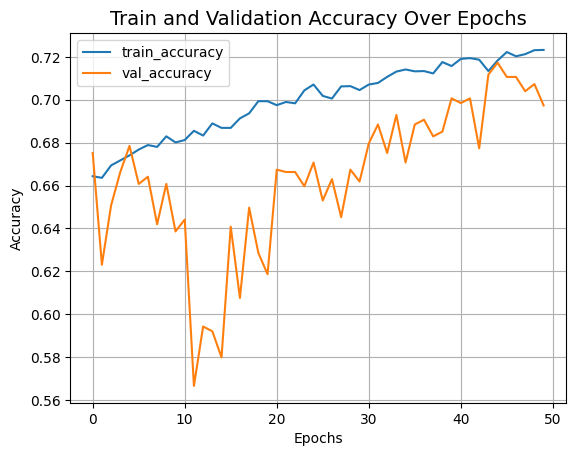

In [ ]:
plt.plot(history.history["accuracy"], label="train_accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train and Validation Accuracy Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()


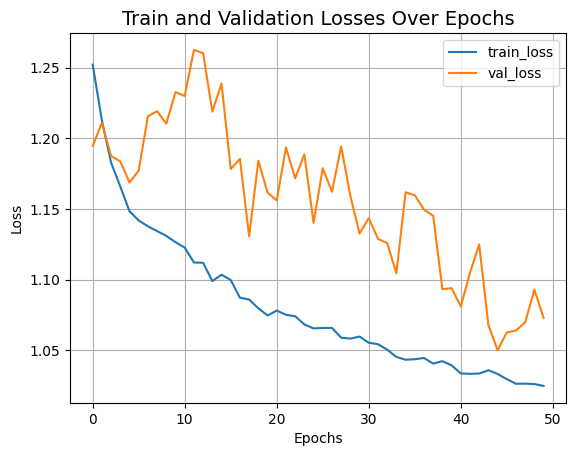

In [ ]:
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()

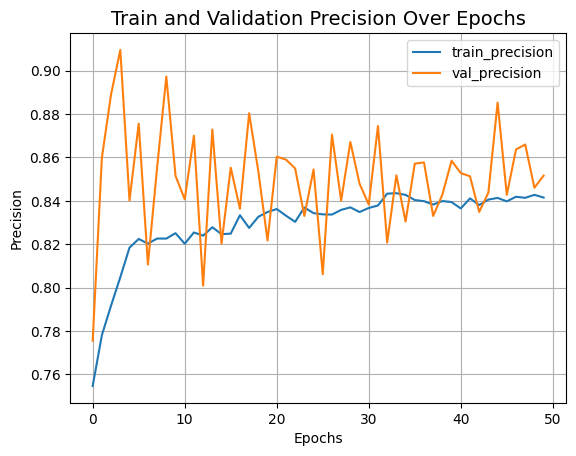

In [ ]:
plt.plot(history.history["precision"], label="train_precision")
plt.plot(history.history["val_precision"], label="val_precision")
plt.xlabel("Epochs")
plt.ylabel("Precision")
plt.title("Train and Validation Precision Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()

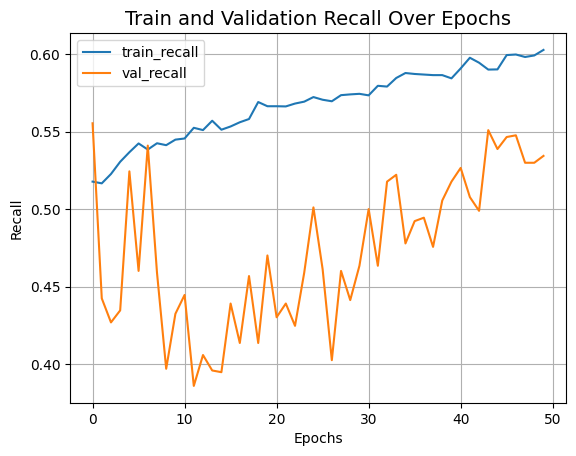

In [ ]:
plt.plot(history.history["recall"], label="train_recall")
plt.plot(history.history["val_recall"], label="val_recall")
plt.xlabel("Epochs")
plt.ylabel("Recall")
plt.title("Train and Validation Recall Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()

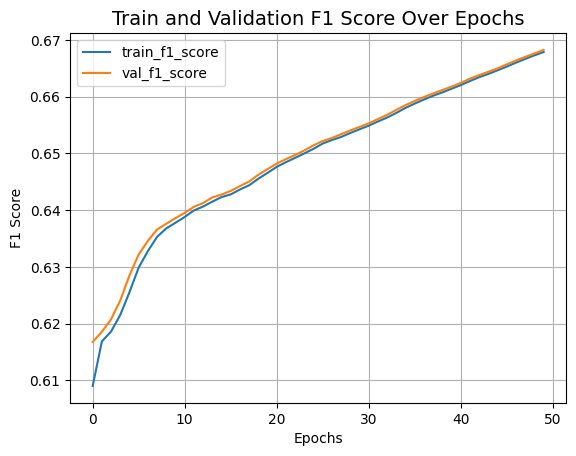

In [ ]:
plt.plot(history.history["f1_score"], label="train_f1_score")
plt.plot(history.history["val_f1_score"], label="val_f1_score")
plt.xlabel("Epochs")
plt.ylabel("F1 Score")
plt.title("Train and Validation F1 Score Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


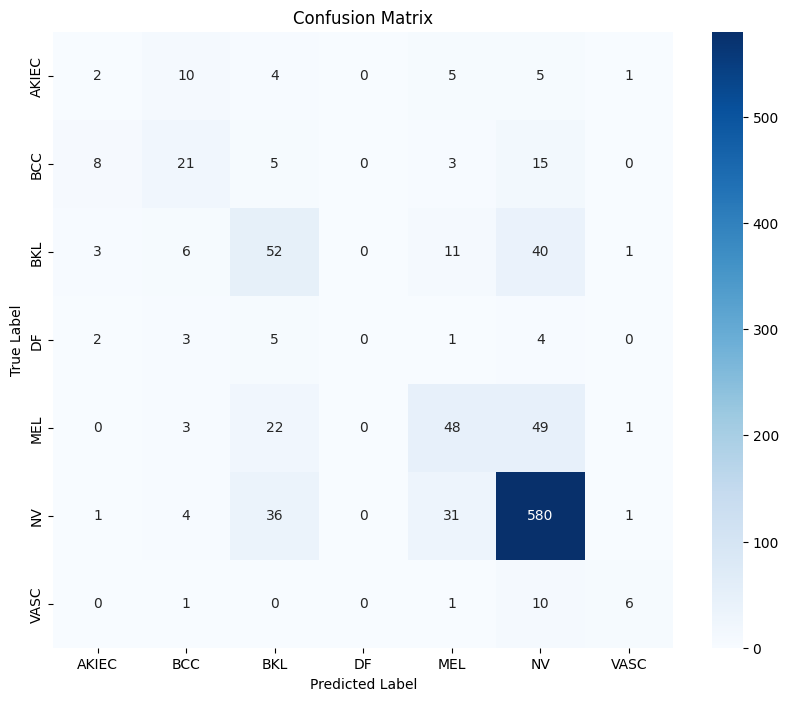

In [ ]:
# List of class names
class_names = ['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC']

# Step 1: Make predictions on the test dataset
y_pred = model.predict(dataset_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert to class labels

# Step 2: Convert true labels to class labels
y_true = np.argmax(y_test, axis=1)  # True labels for the test set

# Step 3: Compute confusion matrix
conf_matrix = metrics.confusion_matrix(y_true, y_pred_classes)

# Step 4: Plot the confusion matrix with class names as axis labels
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


C:\Users\T2330128\AppData\Roaming\Python\Python312\site-packages\keras\src\ops\nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (3136, 8, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


54/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

C:\Users\T2330128\AppData\Roaming\Python\Python312\site-packages\keras\src\ops\nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 8, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


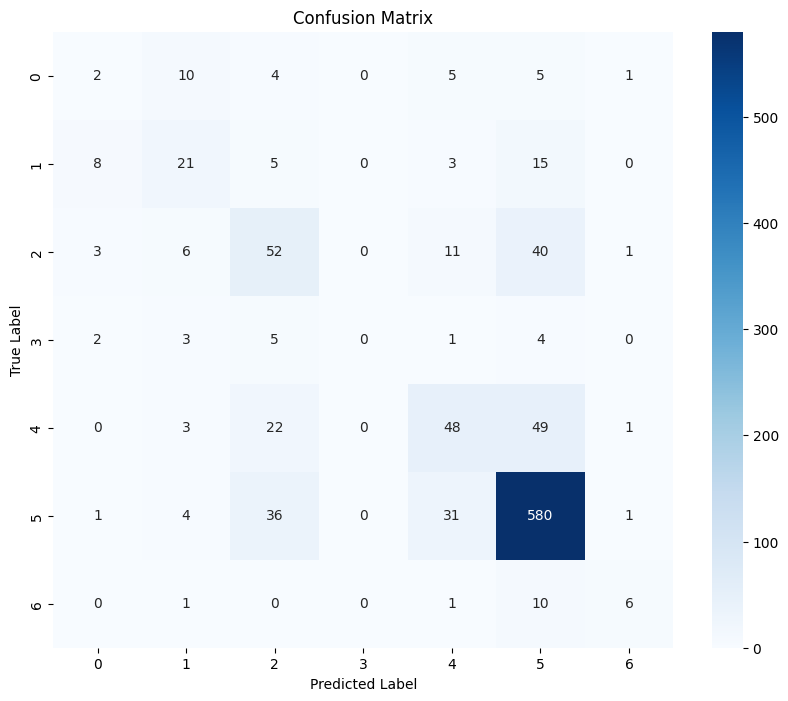

In [ ]:
import sklearn.metrics as metrics
import seaborn as sns

# Step 1: Make predictions on the test dataset
y_pred = model.predict(dataset_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert to class labels

# Step 2: Convert true labels to class labels
y_true = np.argmax(y_test, axis=1)  # True labels for the test set

# Step 3: Compute confusion matrix
conf_matrix = metrics.confusion_matrix(y_true, y_pred_classes)

# Step 4: Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[str(i) for i in range(num_classes)], yticklabels=[str(i) for i in range(num_classes)])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [ ]:
from google.colab import drive


model.save('/content/drive/MyDrive/P2_Dataset/skin_cancer_segmented/swin_transformer_model.keras')
print("Model saved successfully!")

Model saved successfully!


In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('swin_transformer_model.keras')

'''history = model.fit(
    dataset,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_data=dataset_val,
)
'''

C:\Users\T2330128\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\layer.py:393: UserWarning: `build()` was called on layer 'patch_embedding_2', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
C:\Users\T2330128\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\layer.py:393: UserWarning: `build()` was called on layer 'patch_merging_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
C:\Users\T2330128\AppData\Roaming\Python\Python312\site-packages\keras\src\ops\nn.py:907: UserWa

'history = model.fit(\n    dataset,\n    batch_size=batch_size,\n    epochs=num_epochs,\n    validation_data=dataset_val,\n)\n'

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Get class names from your dataset
class_names = train_ds.class_names
model.eval()

# Function to prepare predictions
def prepare_predictions(model, dataset):
    y_true = []
    y_pred = []

    for images, labels in dataset:
        # Get predictions
        predictions = resnet_model.predict(images, verbose=0)

        # Convert one-hot encoded labels back to class indices
        y_true.extend(np.argmax(labels, axis=1))
        y_pred.extend(np.argmax(predictions, axis=1))

    return np.array(y_true), np.array(y_pred)

# Get predictions
y_true, y_pred = prepare_predictions(resnet_model, validation_ds)

# Create and plot confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true, y_pred)

# Calculate percentages
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Create heatmap with both numbers and percentages
sns.heatmap(cm, annot=np.array([[f'{int(x)}\n{y:.1f}%'
                                for x, y in zip(row_a, row_p)]
                               for row_a, row_p in zip(cm, cm_percent)]),
            fmt='', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)

plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))




NameError: name 'train_ds' is not defined

# GradCAM

In [ ]:
model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 196, 768)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ patch_embedding_2 (PatchEmbedding)   │ (None, 196, 32)             │          30,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ swin_transformer_4 (SwinTransformer) │ (None, 196, 32)             │          17,133 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ swin_transformer_5 (SwinTransformer) │ (None, 196, 32)             │          17,329 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ patch_merging_19 (PatchMerging)      │ (None, 49, 64)              │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_2           │ (None, 64)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_41 (Dense)                     │ (None, 7)                   │             455 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 221,573 (866.30 KB)

 Trainable params: 73,791 (288.25 KB)

 Non-trainable params: 198 (1.55 KB)

 Optimizer params: 147,584 (576.50 KB)

method 1 (pytorch)

In [ ]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 87.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.4-py3-none-any.whl size=39588 sha256=61eb5bc0699d59759eafb56778c6b921b12fe6ac0529a21d44d33f81e8484dcf
  Stored in directory: /root/.cache/pip/wheels/50/b0/82/1f97b5348c7fe9f0ce0ba18497202cafa5dec4562bd5292680
Successfully built grad-cam


In [ ]:
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

def reshape_transform(tensor, height=7, width=7):
    result = tensor.reshape(tensor.size(0),
                            height, width, tensor.size(2))

    # Bring the channels to the first dimension,
    # like in CNNs.
    result = result.transpose(2, 3).transpose(1, 2)
    return result

# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

target_layers = [model.layers[-1].blocks[-1].norm2]
targets = [ClassifierOutputTarget(6)]

image_path = '/content/drive/MyDrive/Skin cancer/train/AKIEC/ISIC_0024372.jpg'  # Example path
rgb_img = cv2.imread(image_path)[:, :, ::-1]  # Convert BGR to RGB
rgb_img = cv2.resize(rgb_img, (224, 224))
rgb_img = np.float32(rgb_img) / 255
input_tensor = preprocess_image(rgb_img, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]).to(device)

cam = GradCAM(model=model, target_layers=target_layers, reshape_transform=reshape_transform)
grayscale_cam = cam(input_tensor=input_tensor, targets = targets, aug_smooth=True)
grayscale_cam = grayscale_cam[0, :]  # Extract the CAM for the single image

# Overlay the CAM on the original image
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

# Display the result
plt.imshow(visualization)
plt.axis('off')
plt.show()

AttributeError: 'Dense' object has no attribute 'blocks'

method 2 (keras)

In [ ]:
pip install tf-keras-vis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 4.2 MB/s eta 0:00:00


In [ ]:
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf

def preprocess_input(x):
    x = tf.image.resize(x, (224, 224)) / 255.0
    x = (x - 0.5) / 0.5
    return x

# Define the GradCAM instance
gradcam = Gradcam(model,
                  model_modifier=ReplaceToLinear(),
                  clone=True)

# Target class (e.g., 6 for your example)
score = CategoricalScore(6)

# Preprocess the image
image_path = '/content/drive/MyDrive/Skin cancer/train/AKIEC/ISIC_0024372.jpg'  # Example path
img = cv2.imread(image_path)[:, :, ::-1]  # Convert BGR to RGB
img = np.float32(img) / 255.0
img_tensor = preprocess_input(img)
img_tensor = np.expand_dims(img_tensor, axis=0)

img_tensor = patch_extract(img_tensor).numpy()  # Extract patches and convert to numpy array
# Replace with the actual layer name if needed

# Generate the heatmap
cam = gradcam(score,
              img_tensor,
              penultimate_layer=model.layers[3].'norm2')  # Use the name of the norm2 layer

# Overlay CAM on the image
heatmap = np.uint8(255 * cam[0])
overlay = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
visualization = cv2.addWeighted(np.uint8(img * 255), 0.6, overlay, 0.4, 0)

# Display the visualization
plt.imshow(visualization)
plt.axis('off')
plt.show()


SyntaxError: invalid syntax (<ipython-input-43-4389741e7486>, line 35)